In [1]:
import orbax.checkpoint as ocp
from ml_collections import ConfigDict
from pathlib import Path
from utils import prepare_test_dataset
from dataset_utils import get_dataset
from jax import random
from models.utils import sample_gaussian

import models.ClassifierGFZ as ClassifierGFZ
import models.ClassifierDFZ as ClassifierDFZ

checkpoint_path = "dfz-2-epochs-first-try-1"
path = Path.cwd() / Path(f"checkpoints") / Path(checkpoint_path)
checkpoint = ocp.PyTreeCheckpointer().restore(path, item=None)

config = ConfigDict(checkpoint["config"])
dataset_config = ConfigDict(checkpoint["dataset_config"])

if config.model_name == "GFZ":
    classifier = ClassifierGFZ
elif config.model_name == "DFZ":
    classifier = ClassifierDFZ
else:
    raise NotImplementedError(config.model_name)

_, test_ds = get_dataset(config.dataset)
test_images, test_labels = prepare_test_dataset(
    test_ds, dataset_config
    )

trained_params = checkpoint["params"]

log_likelyhood_fn = classifier.log_likelyhood_A

test_key = random.PRNGKey(config.seed)

test_key, model, _ = classifier.create_and_init(
    test_key, config, dataset_config
)

/Users/alexandrelutt/Desktop/Travail/ENPC/3A/MVA/Probabilistic Graphical Models/adversarial-attacks-on-generative-classifiers/.venv/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1346: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs.
  warnings.warn(


In [2]:
from flax import linen as nn
import jax
from jax import jacrev
import numpy as np
from functools import partial
from jax.scipy.special import logsumexp
import jax.numpy as jnp
import matplotlib.pyplot as plt

idx = np.random.randint(0, len(test_images))

x = test_images[idx]
true_y = test_labels[idx]
true_label = np.argmax(true_y)

K = model.K
batch_size = 1
test_key, epsilon = sample_gaussian(test_key, (batch_size, model.n_classes * K, model.d_latent))
epsilon = epsilon[0]
y = nn.one_hot(jnp.repeat(jnp.arange(model.n_classes), K), model.n_classes, dtype=jnp.float32)

def get_model_output(x, epsilon):
    z, logit_q_z_xy, logit_p_x_z, logit_p_y_xz = jax.vmap(
            partial(model.apply, {'params': trained_params}, train=False),
            in_axes=(None, 0, 0)
        )(x, y, epsilon)

    ll = log_likelyhood_fn(
            z, logit_q_z_xy, logit_p_x_z, logit_p_y_xz
        ).reshape(model.n_classes, K)
    ll = logsumexp(ll, axis=1) - np.log(K)
    return ll

def get_model_jacobian(x, epsilon):
    return jacrev(get_model_output, argnums=0)(x, epsilon)

In [3]:
class DeepFool():
    def __init__(self, model):
        self.model = model
        self.n_classes = model.n_classes

    def get_label(self, x, epsilon):
        val = get_model_output(x, epsilon)
        return np.argmax(val)

    def get_likelihoods_and_gradients(self, x, epsilon):
        J = get_model_jacobian(x, epsilon)
        val = get_model_output(x, epsilon)
        return val, J

    def get_perturbation(self, x, epsilon):
        corrupted_x = x.copy()
        n_iter = 0
        new_label = self.get_label(corrupted_x, epsilon)
        k = self.get_label(x, epsilon)
        while new_label == k:
            best_pert = np.inf
            likelihoods, gradients = self.get_likelihoods_and_gradients(corrupted_x, epsilon)
            for j in range(self.n_classes):
                if j != k:
                    w_j = gradients[j] - gradients[k]
                    f_j = likelihoods[j] - likelihoods[k]
                    pert = np.abs(f_j) / np.linalg.norm(w_j)
                    if pert < best_pert:
                        w = w_j
                        f = f_j
            r_i = (np.abs(f) / np.linalg.norm(w)**2) * w
            corrupted_x = corrupted_x + r_i
            n_iter += 1
            new_label = self.get_label(corrupted_x, epsilon)
        return corrupted_x, new_label

In [4]:
DeepFool = DeepFool(model)
corrupted_x, new_label = DeepFool.get_perturbation(x, epsilon)

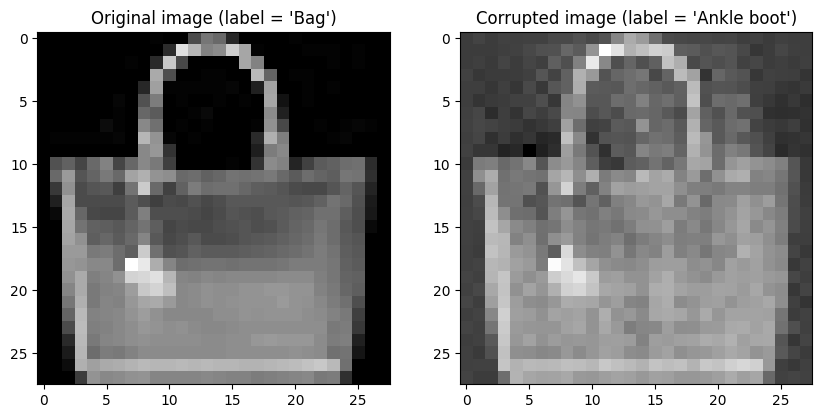

In [5]:
def map_label_to_name(y):
    labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
              "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
    return labels[y]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(x.reshape(28, 28), cmap="gray")
axs[0].set_title(f"Original image (label = '{map_label_to_name(true_label)}')")
axs[1].imshow(corrupted_x.reshape(28, 28), cmap="gray")
axs[1].set_title(f"Corrupted image (label = '{map_label_to_name(new_label)}')")
plt.show()